# Improves
### Dropout
### SGD improvement

In [2]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Functions

In [335]:
# X: c x n np.ndarray
# return a c x n ndarray
def softmax(X):
    X -= X.max(axis=0)  # for each column, substract the max over row
    eX = np.exp(X) 
    return eX / eX.sum(axis=0)  # softmax for each column

In [336]:
# X: a ndarray
def activition(X):
    return np.maximum(X, 0) # ReLu

In [399]:
# y: 1 x n, n: num of sample, class label in [0, c), dtype='uint8'
# Y_soft: c x n, each column is a distr.
def logLoss(y, Y_soft):
    y_prob = Y_soft[y, range(len(y))]  # 1 x n
    #print y_prob.min()
    return -np.log(y_prob).mean()        

In [339]:
# W: a ndarray of weights
# return the regularization penalty
def regularization(W, reg='l2'):
    if reg != 'l2':
        raise
    else:
        return 0.5 * np.sum(W*W)          

# Sample Data

(-1, 1)

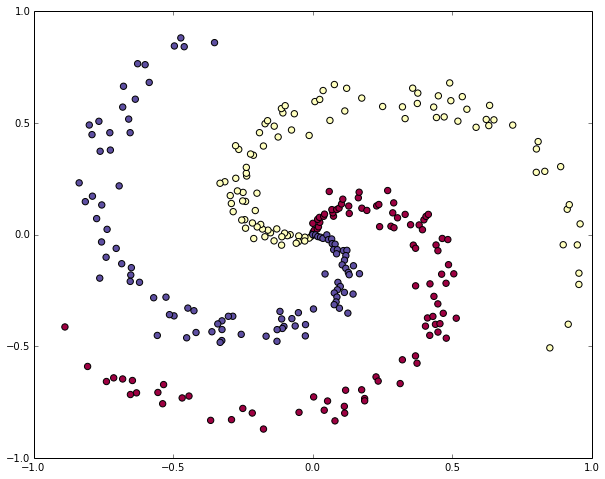

In [340]:
np.random.seed(0)
n = 100 # number of points per class, actually n(sample) = n*c
d = 2 # dimensionality
c = 3 # number of classes
X = np.zeros((d, n*c))
y = np.zeros(n*c, dtype='uint8')
for j in xrange(c):
    cols = range(n*j, n*(j+1))
    r = np.linspace(0.0, 1, n) # radius
    t = np.linspace(j*4, (j+1)*4, n) + np.random.randn(n)*0.2 # theta
    X[:, cols] = np.vstack( (r*np.sin(t), r*np.cos(t)) )
    y[cols] = j
fig = plt.figure()
plt.scatter(X[0, :], X[1, :], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
#fig.savefig('spiral_raw.png')

# Neural Network

In [571]:
class NeuralNetwork:
    name = 'NeuralNetwork' # class variable
    def __init__(self):
        pass

In [572]:
def printAll(self):
    print "W1", self.W1
    print "b1", self.b1
    print "W2", self.W2
    print "b2", self.b2
NeuralNetwork.printAll = printAll

In [573]:
def predict(self, X):
    S1 = self.W1.dot(X) + self.b1   # h x n 
    A1 = activition( S1 ) # h x n 
    S2 = self.W2.dot( A1 ) + self.b2  # c x n
    Y_soft = softmax( S2 )  # c x n
    return Y_soft
NeuralNetwork.predict = predict

In [647]:
# X: d x n
def forwardProp(self, X, y):
    self.S1 = self.W1.dot(X) + self.b1   # h x n 
    self.A1 = activition( self.S1 ) # h x n 
    self.M1 = (np.random.rand(*self.A1.shape) <= self.prob_drop) / self.prob_drop  # dropout mask. Notice /p
    self.A1 *= self.M1  # dropout
    self.S2 = self.W2.dot(self.A1) + self.b2  # c x n
    self.Y_soft = softmax( self.S2 )  # c x n
    # current loss
    self.data_loss = logLoss( y, self.Y_soft )
    self.reg_loss = self.reg * ( regularization(self.W1) + regularization(self.W2) ) 
    self.loss = self.data_loss + self.reg_loss
NeuralNetwork.forwardProp = forwardProp

In [648]:
def backProp(self, X, y):
    n_samp = len(y)
    dS2 =  self.Y_soft # c x n
    dS2[y, range(n_samp)] -= 1.0
    dS2 /= n_samp
    db2 = dS2.sum(axis=1)  # force to a row vector
    db2 = db2.reshape(len(db2), 1) # c x 1
    dW2 = dS2.dot( self.A1.T )  # c x h
    dA1 = self.W2.T.dot( dS2 ) * self.M1  # h x n, consider dropout mask
    dS1 = np.copy( dA1 ) # h x n
    dS1[self.S1<=0] = 0  # ReLu's gradient
    db1 = dS1.sum(axis=1) # force to a row vector
    db1 = db1.reshape(len(db1), 1)  # h x 1
    dW1 = dS1.dot( X.T ) # h x d
    
    ## update W1, b1, W2, b2
    dW1 += self.reg * self.W1
    dW2 += self.reg * self.W2
 
    self.b1 += -self.step * db1
    self.W1 += -self.step * dW1
    self.b2 += -self.step * db2
    self.W2 += -self.step * dW2
NeuralNetwork.backProp = backProp

In [658]:
def param_init(self):
    self.step = 1e-0 # SGD step
    self.reg = 1e-2  # regularization strength
    self.prob_drop = 0.5 # dropout probability
    self.d = 2 # feature dimension
    self.c = 3 # number of classes
    self.h = 100 # size of hidden layer
    self.W1 = np.random.randn( self.h, self.d ) * np.sqrt(2.0/(self.h * self.d)) # calibrate variance
    self.b1 = np.zeros( (self.h, 1) )
    self.W2 = np.random.randn( self.c, self.h ) * np.sqrt(2.0/(self.c * self.h))
    self.b2 = np.zeros( (self.c, 1) )
NeuralNetwork.param_init = param_init

In [659]:
def fit(self, X, y, n_iter=10001):
    self.param_init() # W1, W2, b1, b2
    for i in xrange(n_iter):
        self.forwardProp(X, y)
        self.backProp(X, y)
        if i % 100 == 0:
            print "iter %d: loss = %f" % ( i, self.loss )
        #self.printAll()
NeuralNetwork.fit = fit

In [660]:
nn = NeuralNetwork()

In [661]:
nn.fit(X, y)

iter 0: loss = 1.119535
iter 100: loss = 0.823211
iter 200: loss = 0.793545
iter 300: loss = 0.783944
iter 400: loss = 0.786659
iter 500: loss = 0.789932
iter 600: loss = 0.759877
iter 700: loss = 0.773637
iter 800: loss = 0.768842
iter 900: loss = 0.779001
iter 1000: loss = 0.757574
iter 1100: loss = 0.776556
iter 1200: loss = 0.763078
iter 1300: loss = 0.772786
iter 1400: loss = 0.762311
iter 1500: loss = 0.792949
iter 1600: loss = 0.757501
iter 1700: loss = 0.776414
iter 1800: loss = 0.767295
iter 1900: loss = 0.752090
iter 2000: loss = 0.758713
iter 2100: loss = 0.765570
iter 2200: loss = 0.774145
iter 2300: loss = 0.770527
iter 2400: loss = 0.786164
iter 2500: loss = 0.774028
iter 2600: loss = 0.761699
iter 2700: loss = 0.780058
iter 2800: loss = 0.780715
iter 2900: loss = 0.775262
iter 3000: loss = 0.774002
iter 3100: loss = 0.751677
iter 3200: loss = 0.770021
iter 3300: loss = 0.791513
iter 3400: loss = 0.767675
iter 3500: loss = 0.798181
iter 3600: loss = 0.777373
iter 3700: lo

# Training

### Evaluation

### Plot Classification Boundary

In [662]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
# xx, yy are two matrix, each pair (xx_i, yy_i) is a location
print xx.shape, yy.shape

(188, 193) (188, 193)


In [663]:
XX = np.c_[xx.ravel(), yy.ravel()].T
print XX.shape, yy.shape

(2, 36284) (188, 193)


(-1.8712034092398278, 1.8687965907601756)

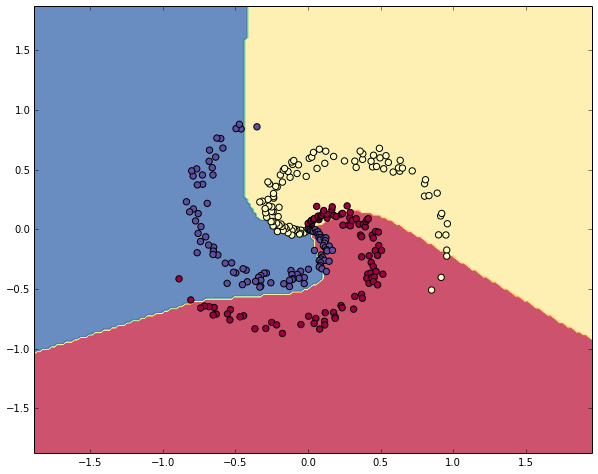

In [664]:
Z = nn.predict( XX ) # c x n
Z = np.argmax(Z, axis=0)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[0, :], X[1, :], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#fig.savefig('spiral_linear.png')

In [665]:
Y_soft = nn.predict(X) 
predicted_class = np.argmax(Y_soft, axis=0)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.72


In [666]:
np.argmax(Y_soft, axis=0)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2])